=== Online Market Discovery - NOTEBOOK 4: ADVANCED ANALYSIS ===
⚠️  ALIGNED WITH NOTEBOOKS 1-3 METHODOLOGY:
   ✅ Domain-level aggregation BEFORE train-test split
   ✅ Proper NaN handling and data cleaning
   ✅ Cross-validation for robust evaluation
   ✅ Multilingual features + Store classification
   ✅ Sampling for development speed

🔧 CONFIGURATION:
   📊 Sample size: 100,000 rows (for fast development)
   🎲 Random state: 42
--------------------------------------------------

STEP 1: LOADING AND PREPARING DATA
--------------------------------------------------
🔍 Original dataset: 2,722,487 URL-level samples
📊 Sampled dataset: 100,000 URL-level samples

STEP 2: MULTILINGUAL FEATURE ENGINEERING
--------------------------------------------------
🔧 Creating multilingual features...
   Progress: 0/100,000 (0.0%)
   Progress: 1,000/100,000 (1.0%)
   Progress: 2,000/100,000 (2.0%)
   Progress: 3,000/100,000 (3.0%)
   Progress: 4,000/100,000 (4.0%)
   Progress: 5,000/100,000 (5.0%)
   Progress

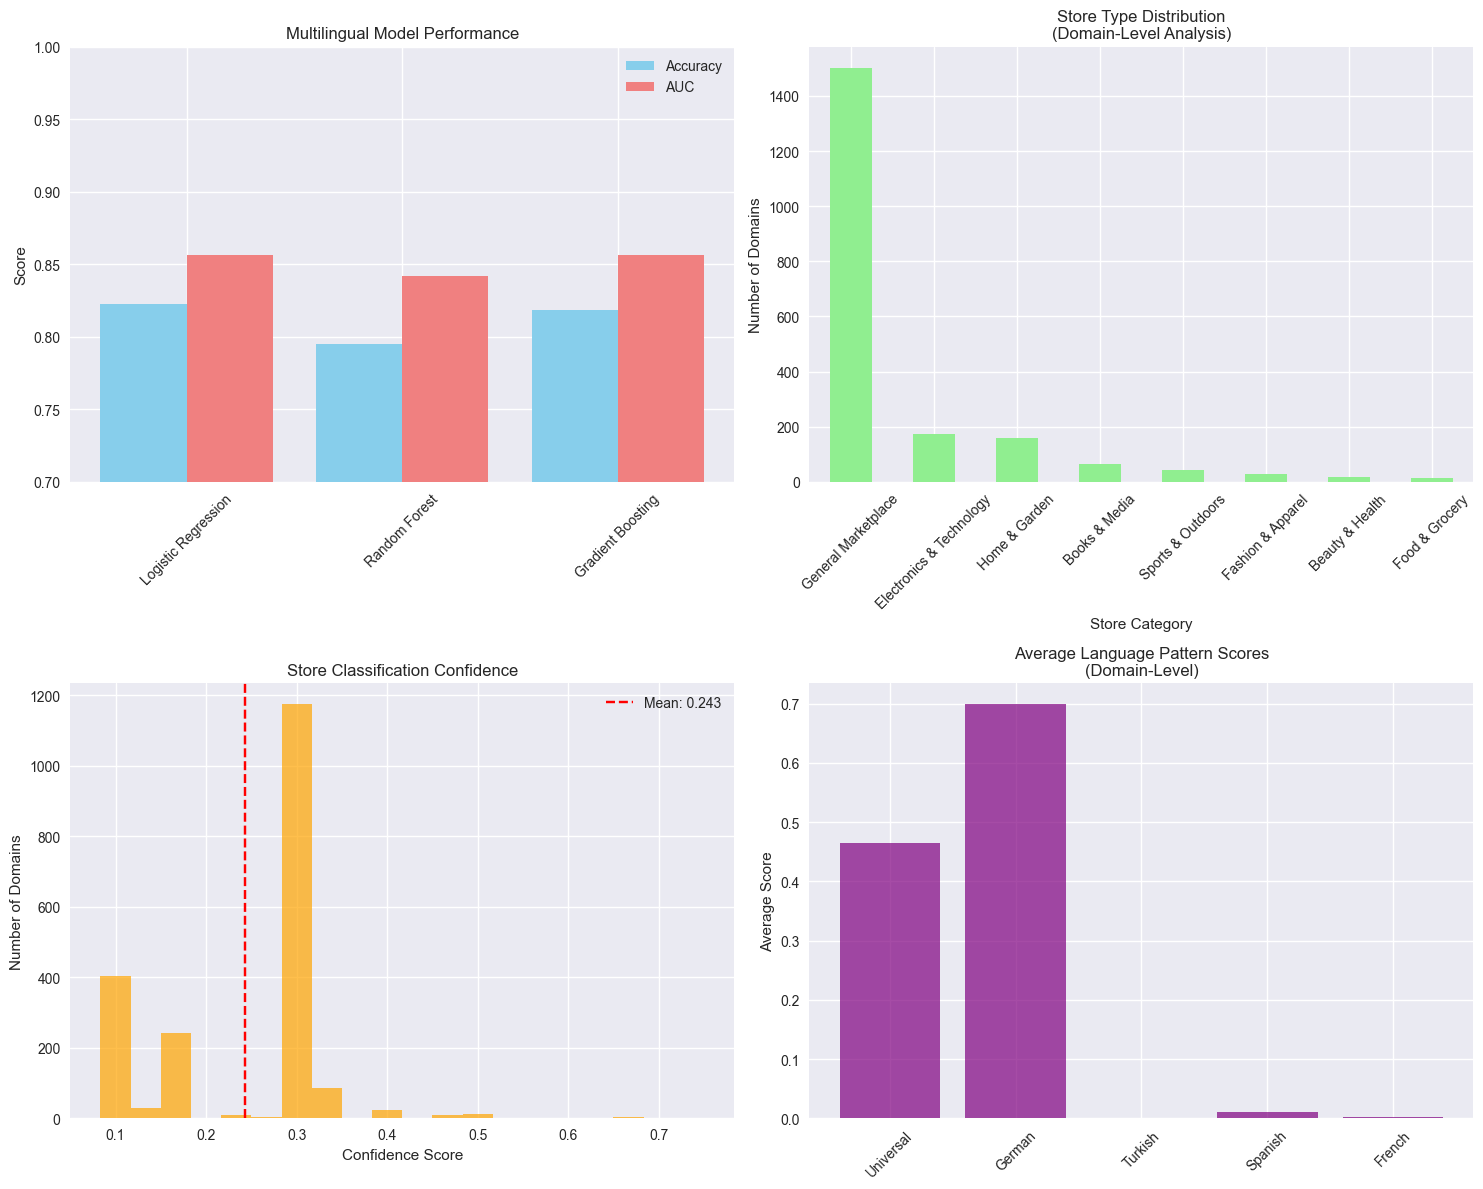

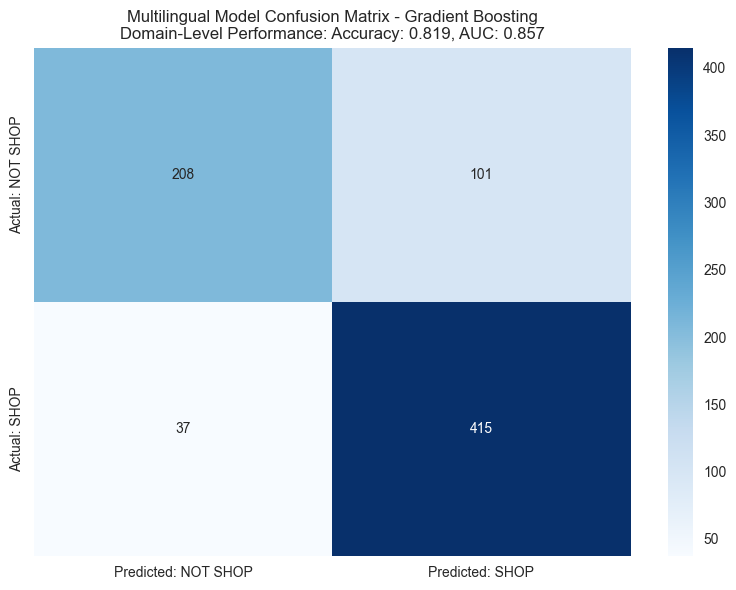


📊 FEATURE IMPORTANCE ANALYSIS (Gradient Boosting):

📊 Top 15 Numerical Features (Multilingual):
   universal_price_count_mean: 0.1615
   multilingual_total_score_mean: 0.1278
   brand_in_title_mean: 0.0719
   has_price_pattern_mean: 0.0192
   snippet_length_mean: 0.0102
   snippet_length_max: 0.0094
   path_depth_mean: 0.0077
   url_length_mean: 0.0073
   text_length_mean: 0.0057
   url_length_max: 0.0053
   universal_shop_score_mean: 0.0045
   text_length_max: 0.0041
   num_words_mean: 0.0037
   german_shop_score_mean: 0.0029
   has_product_code_mean: 0.0025


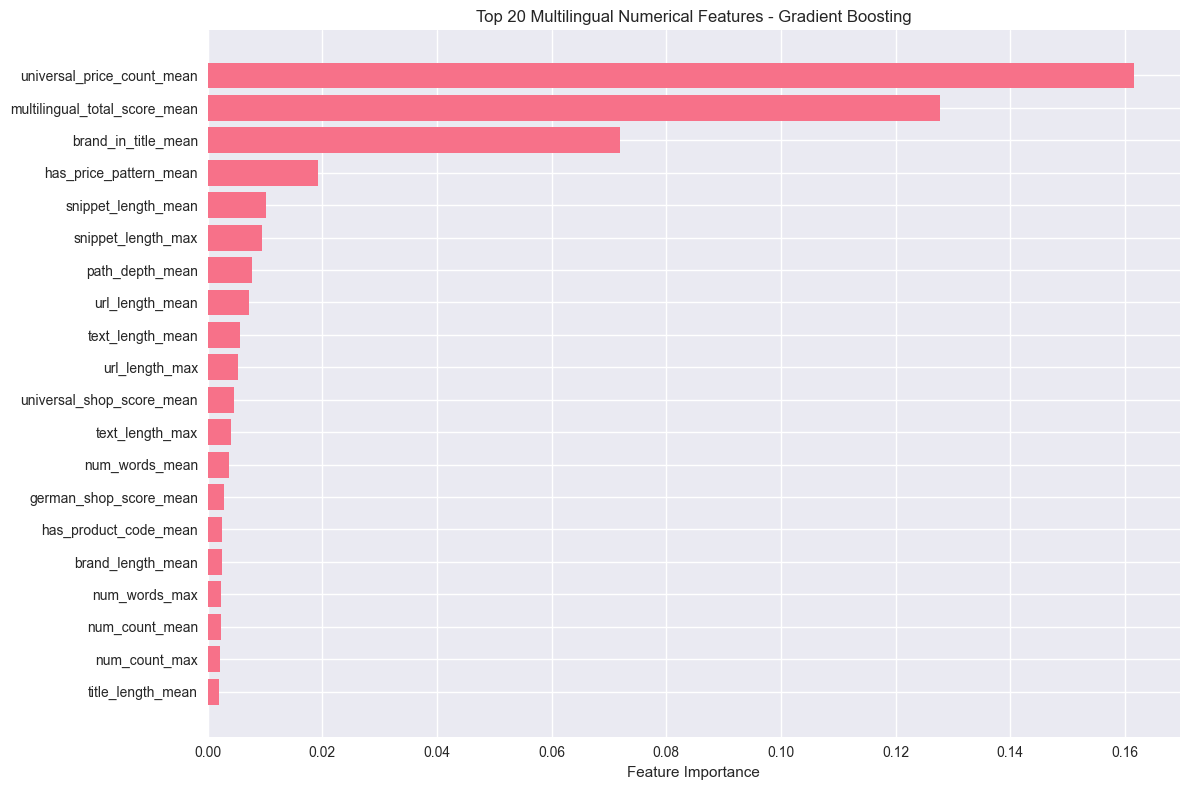


STEP 7: SAVE RESULTS
--------------------------------------------------
✅ Saved multilingual model: multilingual_model_sample_100k.pkl
✅ Saved all results: multilingual_results_sample_100k.pkl
✅ Saved multilingual dataset: domain_multilingual_dataset_sample_100k.csv
✅ Saved store classifications: store_classifications_sample_100k.csv
✅ Added multilingual prediction function to model package

✅ NOTEBOOK 4 COMPLETE - MULTILINGUAL FRAMEWORK & STORE CLASSIFICATION

🎯 MULTILINGUAL MODEL PERFORMANCE:
   🏆 Best Model: Gradient Boosting
   📈 Domain-level Accuracy: 0.8187
   📈 Domain-level AUC: 0.8565
   📈 Cross-validation AUC: 0.8793 (±0.0115)

🌍 MULTILINGUAL CAPABILITIES:
   🗣️ Languages: German, English, Turkish, Spanish, French
   🔧 Features: 85 domain-level features
   🌐 International ready: Pattern matching across languages

🏪 STORE CLASSIFICATION INSIGHTS:
   📊 Analyzed: 2,000 online shop domains
   🎯 Categories: 8 different store types
   📈 Avg Confidence: 0.243

🔢 DATASET STATISTICS:


In [2]:
# =============================================================================
# NOTEBOOK 4 - MULTILINGUAL FRAMEWORK & STORE CLASSIFICATION (FIXED)
# =============================================================================
# This version is ALIGNED with Notebooks 1-3 methodology and fixes all issues

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re  # FIXED: Added re import here
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, roc_auc_score, roc_curve, 
                           classification_report, confusion_matrix, precision_recall_curve)
from sklearn.pipeline import Pipeline
from scipy.sparse import hstack
import joblib
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== Online Market Discovery - NOTEBOOK 4: ADVANCED ANALYSIS ===")
print("⚠️  ALIGNED WITH NOTEBOOKS 1-3 METHODOLOGY:")
print("   ✅ Domain-level aggregation BEFORE train-test split")
print("   ✅ Proper NaN handling and data cleaning")
print("   ✅ Cross-validation for robust evaluation")
print("   ✅ Multilingual features + Store classification")
print("   ✅ Sampling for development speed")
print("="*70 + "\n")

# =============================================================================
# CONFIGURATION
# =============================================================================
SAMPLE_SIZE = 100000  # Set to None for full dataset
RANDOM_STATE = 42

print("🔧 CONFIGURATION:")
if SAMPLE_SIZE:
    print(f"   📊 Sample size: {SAMPLE_SIZE:,} rows (for fast development)")
else:
    print("   📊 Using full dataset")
print(f"   🎲 Random state: {RANDOM_STATE}")
print("-" * 50)

# =============================================================================
# ENHANCED MULTILINGUAL FEATURE EXTRACTION
# =============================================================================

def extract_multilingual_features(url, title, snippet, brand):
    """
    Extract multilingual features - ALIGNED with Notebooks 1-3 style
    """
    # Handle missing values (same as Notebooks 1-3)
    url = str(url).lower() if pd.notna(url) else ""
    title = str(title).lower() if pd.notna(title) else ""
    snippet = str(snippet).lower() if pd.notna(snippet) else ""
    brand = str(brand).lower() if pd.notna(brand) else ""
    
    combined_text = f"{title} {snippet}"
    
    features = {}
    
    # === URL STRUCTURE FEATURES (from Notebook 3) ===
    features['url_length'] = len(url)
    features['num_subdomains'] = url.count('.') - 1 if '.' in url else 0
    features['has_https'] = 1 if url.startswith('https') else 0
    
    # Extract domain and path (same logic as Notebook 3)
    try:
        if '://' in url:
            after_protocol = url.split('://', 1)[1]
            domain_part = after_protocol.split('/', 1)[0]
            path_part = after_protocol.split('/', 1)[1] if '/' in after_protocol else ""
        else:
            domain_part = url.split('/', 1)[0]
            path_part = url.split('/', 1)[1] if '/' in url else ""
    except:
        domain_part = ""
        path_part = ""
    
    features['domain_length'] = len(domain_part)
    features['path_depth'] = path_part.count('/') if path_part else 0
    features['has_www'] = 1 if 'www.' in url else 0
    
    # === MULTILINGUAL E-COMMERCE PATTERNS ===
    # Universal patterns (English-based)
    universal_shop_patterns = ['shop', 'store', 'buy', 'cart', 'checkout', 'product', 
                              'order', 'purchase', 'delivery', 'shipping', 'price']
    features['universal_shop_score'] = sum(1 for pattern in universal_shop_patterns 
                                         if pattern in combined_text or pattern in url)
    
    # German patterns (from Notebook 3)
    german_shop_patterns = ['online shop', 'onlineshop', 'webshop', 'versand', 
                           'lieferung', 'bestellen', 'kaufen', 'verkauf', 'laden']
    features['german_shop_score'] = sum(1 for pattern in german_shop_patterns 
                                       if pattern in combined_text or pattern in url)
    
    # NEW: Additional language patterns for international expansion
    # Turkish patterns
    turkish_shop_patterns = ['mağaza', 'satın', 'sepet', 'ürün', 'fiyat', 'kargo', 
                            'teslimat', 'sipariş', 'alışveriş']
    features['turkish_shop_score'] = sum(1 for pattern in turkish_shop_patterns 
                                        if pattern in combined_text or pattern in url)
    
    # Spanish patterns
    spanish_shop_patterns = ['tienda', 'comprar', 'carrito', 'producto', 'precio',
                            'oferta', 'envío', 'pedido', 'compra']
    features['spanish_shop_score'] = sum(1 for pattern in spanish_shop_patterns 
                                        if pattern in combined_text or pattern in url)
    
    # French patterns
    french_shop_patterns = ['magasin', 'acheter', 'panier', 'produit', 'prix',
                           'livraison', 'commande', 'boutique']
    features['french_shop_score'] = sum(1 for pattern in french_shop_patterns 
                                       if pattern in combined_text or pattern in url)
    
    # === UNIVERSAL CURRENCY AND PRICE INDICATORS ===
    price_symbols = ['€', '$', '£', '¥', '₺', '₽', 'usd', 'eur', 'gbp', 'jpy']
    features['universal_price_count'] = sum(1 for symbol in price_symbols 
                                           if symbol in combined_text)
    
    # Price number patterns
    features['has_price_pattern'] = 1 if re.search(r'[€$£¥₺₽]\s*\d+|\d+\s*[€$£¥₺₽]', combined_text) else 0
    
    # === TEXT CONTENT FEATURES (same as Notebook 3) ===
    features['title_length'] = len(title)
    features['snippet_length'] = len(snippet)
    features['text_length'] = len(combined_text)
    features['num_words'] = len(combined_text.split())
    
    # === BRAND FEATURES (same as Notebook 3) ===
    features['has_brand'] = 1 if brand and brand != 'nan' else 0
    features['brand_length'] = len(brand) if brand and brand != 'nan' else 0
    features['brand_in_title'] = 1 if brand and brand != 'nan' and brand in title else 0
    
    # Known international platforms
    global_platforms = ['amazon', 'ebay', 'zalando', 'otto', 'alibaba', 'aliexpress']
    features['is_global_platform'] = 1 if any(platform in url for platform in global_platforms) else 0
    
    # === ADVANCED URL PATTERNS ===
    features['has_product_in_url'] = 1 if any(x in url for x in ['/product/', '/p/', '/artikel/', '/item/']) else 0
    features['has_category_in_url'] = 1 if any(x in url for x in ['/category/', '/c/', '/kategorie/', '/cat/']) else 0
    features['has_cart_in_url'] = 1 if any(x in url for x in ['/cart', '/basket', '/warenkorb']) else 0
    
    # === MULTILINGUAL READINESS SCORE ===
    features['multilingual_total_score'] = (
        features['universal_shop_score'] + 
        features['german_shop_score'] + 
        features['turkish_shop_score'] + 
        features['spanish_shop_score'] + 
        features['french_shop_score']
    )
    
    # === NUMBERS AND SPECIAL CHARACTERS (from Notebook 3) ===
    numbers = re.findall(r'\d+', combined_text)
    features['num_count'] = len(numbers)
    features['has_product_code'] = 1 if any(len(num) > 5 for num in numbers) else 0
    features['special_char_count'] = sum(1 for char in combined_text if char in '€$£%+-,.')
    
    return features

# =============================================================================
# STORE TYPE CLASSIFICATION FUNCTIONS
# =============================================================================

def classify_store_type(url, title, snippet, brand):
    """
    Classify store type based on content analysis
    """
    text = f"{title} {snippet} {brand}".lower()
    url_lower = url.lower()
    
    # Define store categories with multilingual keywords
    store_categories = {
        'Fashion & Apparel': {
            'keywords': ['fashion', 'clothing', 'clothes', 'apparel', 'dress', 'shirt', 'shoes',
                        'mode', 'kleidung', 'schuhe', 'bekleidung', 'moda', 'ropa'],
            'weight': 1.0
        },
        'Electronics & Technology': {
            'keywords': ['electronic', 'computer', 'laptop', 'phone', 'tech', 'gadget',
                        'elektronik', 'handy', 'technik', 'teknoloji', 'bilgisayar'],
            'weight': 1.0
        },
        'Home & Garden': {
            'keywords': ['home', 'garden', 'furniture', 'decor', 'kitchen',
                        'haus', 'garten', 'möbel', 'küche', 'ev', 'bahçe'],
            'weight': 0.9
        },
        'Beauty & Health': {
            'keywords': ['beauty', 'cosmetic', 'health', 'pharmacy', 'wellness',
                        'kosmetik', 'gesundheit', 'apotheke', 'güzellik', 'sağlık'],
            'weight': 0.9
        },
        'Sports & Outdoors': {
            'keywords': ['sport', 'fitness', 'outdoor', 'bike', 'gym',
                        'sport', 'fitness', 'fahrrad', 'spor', 'açık hava'],
            'weight': 0.8
        },
        'Food & Grocery': {
            'keywords': ['food', 'grocery', 'supermarket', 'organic', 'fresh',
                        'lebensmittel', 'essen', 'supermarkt', 'yiyecek', 'market'],
            'weight': 0.8
        },
        'Books & Media': {
            'keywords': ['book', 'media', 'music', 'movie', 'magazine',
                        'buch', 'bücher', 'musik', 'film', 'kitap', 'müzik'],
            'weight': 0.7
        },
        'General Marketplace': {
            'keywords': ['marketplace', 'shop', 'store', 'mall', 'general',
                        'marktplatz', 'kaufhaus', 'pazar', 'mağaza'],
            'weight': 0.5
        }
    }
    
    # Calculate scores
    category_scores = {}
    for category, info in store_categories.items():
        score = 0
        for keyword in info['keywords']:
            if keyword in text:
                score += info['weight']
            if keyword in url_lower:
                score += info['weight'] * 0.5
        category_scores[category] = score
    
    # Get best category
    if max(category_scores.values()) > 0:
        best_category = max(category_scores, key=category_scores.get)
        confidence = min(category_scores[best_category] / 3.0, 1.0)
    else:
        best_category = 'General Marketplace'
        confidence = 0.3
    
    return best_category, confidence

# =============================================================================
# DOMAIN-LEVEL AGGREGATION (ALIGNED WITH NOTEBOOK 3)
# =============================================================================

def aggregate_to_domain_level_multilingual(df):
    """
    Domain-level aggregation - SAME METHODOLOGY as Notebook 3
    """
    print("🗂️ Aggregating to domain level with multilingual features...")
    
    # Combine text for better representation
    df['combined_text'] = df['title'].fillna('') + ' ' + df['snippet'].fillna('')
    
    # Define feature columns (numerical only)
    feature_columns = [col for col in df.columns if col not in 
                      ['domain', 'is_online_shop', 'url', 'title', 'snippet', 'brand', 'combined_text']]
    
    print(f"📊 Feature columns for aggregation: {len(feature_columns)}")
    
    # First, handle the target separately
    domain_targets = df.groupby('domain')['is_online_shop'].agg(
        lambda x: 'YES' if (x == 'YES').any() else 'NO'
    ).reset_index()
    
    # Handle text aggregation separately
    domain_text = df.groupby('domain')['combined_text'].agg(
        lambda x: ' '.join(x.fillna(''))
    ).reset_index()
    
    # Custom aggregation that handles NaN (SAME as Notebook 3)
    agg_results = []
    
    for domain, group in df.groupby('domain'):
        row = {'domain': domain}
        
        # Add URL count
        row['url_count'] = len(group)
        
        # Add first URL and brand for reference
        row['url'] = group['url'].iloc[0]
        row['brand'] = group['brand'].mode().iloc[0] if len(group['brand'].mode()) > 0 else group['brand'].iloc[0]
        
        # Aggregate numerical features
        for feature in feature_columns:
            if feature in group.columns:
                values = group[feature]
                row[f'{feature}_mean'] = values.mean()
                row[f'{feature}_max'] = values.max()
                row[f'{feature}_std'] = values.std() if len(values) > 1 else 0.0
        
        agg_results.append(row)
    
    domain_df = pd.DataFrame(agg_results)
    
    # Merge with target and text
    domain_df = domain_df.merge(domain_targets, on='domain')
    domain_df = domain_df.merge(domain_text, on='domain')
    
    # Handle any remaining NaN values (SAME as Notebook 3)
    print("🔧 Handling NaN values...")
    nan_counts_before = domain_df.isnull().sum().sum()
    
    for col in domain_df.columns:
        if domain_df[col].dtype in ['float64', 'int64']:
            domain_df[col] = domain_df[col].fillna(0)
        elif domain_df[col].dtype == 'object':
            domain_df[col] = domain_df[col].fillna('')
    
    nan_counts_after = domain_df.isnull().sum().sum()
    print(f"   Filled {nan_counts_before} NaN values → {nan_counts_after} remaining")
    
    print(f"✅ Aggregated from {len(df):,} URLs to {len(domain_df):,} domains")
    
    url_counts = domain_df['url_count']
    print(f"📊 URLs per domain: min={url_counts.min()}, "
          f"max={url_counts.max()}, avg={url_counts.mean():.1f}")
    
    # Show target distribution
    target_dist = domain_df['is_online_shop'].value_counts()
    print(f"📈 Domain-level target distribution:")
    print(f"   - Online shops: {target_dist.get('YES', 0):,} ({target_dist.get('YES', 0)/len(domain_df)*100:.1f}%)")
    print(f"   - Not shops: {target_dist.get('NO', 0):,} ({target_dist.get('NO', 0)/len(domain_df)*100:.1f}%)")
    
    return domain_df

# =============================================================================
# LOAD AND PREPARE DATA
# =============================================================================
print("\nSTEP 1: LOADING AND PREPARING DATA")
print("-"*50)

df = pd.read_csv('DE_online_market_discovery_train.csv')
print(f"🔍 Original dataset: {len(df):,} URL-level samples")

# Apply sampling if specified (SAME as Notebook 3)
if SAMPLE_SIZE and len(df) > SAMPLE_SIZE:
    # Stratified sampling to maintain class distribution
    df_yes = df[df['is_online_shop'] == 'YES']
    df_no = df[df['is_online_shop'] == 'NO']
    
    total_yes = len(df_yes)
    total_no = len(df_no)
    yes_ratio = total_yes / len(df)
    
    sample_yes = min(int(SAMPLE_SIZE * yes_ratio), total_yes)
    sample_no = min(SAMPLE_SIZE - sample_yes, total_no)
    
    df_sample_yes = df_yes.sample(n=sample_yes, random_state=RANDOM_STATE)
    df_sample_no = df_no.sample(n=sample_no, random_state=RANDOM_STATE)
    
    df = pd.concat([df_sample_yes, df_sample_no], ignore_index=True)
    df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    
    print(f"📊 Sampled dataset: {len(df):,} URL-level samples")

# =============================================================================
# MULTILINGUAL FEATURE ENGINEERING
# =============================================================================
print("\n" + "="*70)
print("STEP 2: MULTILINGUAL FEATURE ENGINEERING")
print("-"*50)

def create_multilingual_features(df):
    """Create multilingual features with progress tracking"""
    print("🔧 Creating multilingual features...")
    
    features_list = []
    total_rows = len(df)
    progress_step = max(1000, total_rows // 100)
    
    for idx, row in df.iterrows():
        if idx % progress_step == 0:
            progress = idx / total_rows * 100
            print(f"   Progress: {idx:,}/{total_rows:,} ({progress:.1f}%)")
        
        features = extract_multilingual_features(
            row.get('url', ''),
            row.get('title', ''),
            row.get('snippet', ''),
            row.get('brand', '')
        )
        
        # Add metadata
        features['domain'] = row.get('domain', '')
        features['is_online_shop'] = row.get('is_online_shop', '')
        features['url'] = row.get('url', '')
        features['title'] = row.get('title', '')
        features['snippet'] = row.get('snippet', '')
        features['brand'] = row.get('brand', '')
        
        features_list.append(features)
    
    return pd.DataFrame(features_list)

# Create multilingual features
df_multilingual = create_multilingual_features(df)
print(f"✅ Created {len(df_multilingual.columns)} total columns")

# Show feature statistics
feature_cols = [col for col in df_multilingual.columns if col not in 
               ['domain', 'is_online_shop', 'url', 'title', 'snippet', 'brand']]
print(f"\n📊 Multilingual Feature Statistics:")
print(df_multilingual[feature_cols].describe().round(2))

# =============================================================================
# DOMAIN-LEVEL AGGREGATION
# =============================================================================
print("\n" + "="*70)
print("STEP 3: DOMAIN-LEVEL AGGREGATION")
print("-"*50)

domain_df = aggregate_to_domain_level_multilingual(df_multilingual)

# =============================================================================
# MODEL TRAINING (SAME METHODOLOGY AS NOTEBOOK 3)
# =============================================================================
print("\n" + "="*70)
print("STEP 4: MULTILINGUAL MODEL TRAINING")
print("-"*50)

# Prepare data (SAME as Notebook 3)
y_domain = (domain_df['is_online_shop'] == 'YES').astype(int)

# Select feature columns
feature_cols_for_model = [col for col in domain_df.columns if 
                         any(col.endswith(suffix) for suffix in ['_mean', '_max', '_std']) or col == 'url_count']

feature_cols_for_model = [col for col in feature_cols_for_model 
                         if col in domain_df.columns and not col.startswith('is_online_shop')]

X_numerical = domain_df[feature_cols_for_model]

# Verify no NaN values
nan_count = X_numerical.isnull().sum().sum()
if nan_count > 0:
    print(f"⚠️ Found {nan_count} NaN values in numerical features - filling with 0")
    X_numerical = X_numerical.fillna(0)

# Handle text
X_text = domain_df['combined_text'].fillna('')

print(f"📊 Numerical features: {X_numerical.shape}")
print(f"📝 Text features: {len(X_text)} samples")
print(f"🎯 Target distribution: {y_domain.value_counts().to_dict()}")

# Domain-level train-test split
X_train_num, X_val_num, X_train_txt, X_val_txt, y_train, y_val, train_domains, val_domains = train_test_split(
    X_numerical, X_text, y_domain, domain_df['domain'],
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y_domain
)

print(f"✅ Training set: {len(X_train_num):,} domains")
print(f"✅ Validation set: {len(X_val_num):,} domains")

# Verify no overlap
train_domain_set = set(train_domains)
val_domain_set = set(val_domains)
overlap = train_domain_set.intersection(val_domain_set)
print(f"🔍 Domain overlap check: {len(overlap)} domains (should be 0)")

if len(overlap) == 0:
    print("✅ CONFIRMED: No domain overlap - prevents data leakage!")

# Create pipelines (SAME as Notebook 3)
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=3000,
        ngram_range=(1, 2),
        stop_words='english',
        min_df=2,
        max_df=0.8,
        sublinear_tf=True
    ))
])

num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Define models
models = {
    'Logistic Regression': LogisticRegression(
        random_state=RANDOM_STATE, 
        max_iter=1000,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        random_state=RANDOM_STATE, 
        n_estimators=100,
        max_depth=8,
        min_samples_split=5,
        class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        random_state=RANDOM_STATE, 
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5
    ),
}

results = {}

for name, model in models.items():
    print(f"\n⏳ Training {name}...")
    
    # Process features with NaN handling (SAME as Notebook 3)
    print("   🔧 Processing text features...")
    tfidf_train = text_pipeline.fit_transform(X_train_txt.fillna(''))
    tfidf_val = text_pipeline.transform(X_val_txt.fillna(''))
    
    print("   🔧 Processing numerical features...")
    X_train_num_clean = X_train_num.fillna(0)
    X_val_num_clean = X_val_num.fillna(0)
    
    num_train = num_pipeline.fit_transform(X_train_num_clean)
    num_val = num_pipeline.transform(X_val_num_clean)
    
    # Combine features
    print("   🔧 Combining features...")
    X_train_combined = hstack([tfidf_train, num_train])
    X_val_combined = hstack([tfidf_val, num_val])
    
    # Final NaN check (SAME as Notebook 3)
    if hasattr(X_train_combined, 'data'):
        nan_in_train = np.isnan(X_train_combined.data).sum()
        if nan_in_train > 0:
            X_train_combined.data = np.nan_to_num(X_train_combined.data, nan=0.0)
            X_val_combined.data = np.nan_to_num(X_val_combined.data, nan=0.0)
    
    # Train model
    model.fit(X_train_combined, y_train)
    
    # Evaluate
    y_pred = model.predict(X_val_combined)
    y_proba = model.predict_proba(X_val_combined)[:, 1]
    
    accuracy = accuracy_score(y_val, y_pred)
    auc_score = roc_auc_score(y_val, y_proba)
    
    # Cross-validation
    cv_folds = 3 if SAMPLE_SIZE and SAMPLE_SIZE < 50000 else 5
    cv_scores = cross_val_score(model, X_train_combined, y_train, 
                               cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE),
                               scoring='roc_auc')
    
    print(f"   → Validation Accuracy: {accuracy:.4f}")
    print(f"   → Validation AUC: {auc_score:.4f}")
    print(f"   → Cross-validation AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    
    results[name] = {
        'accuracy': accuracy,
        'auc': auc_score,
        'cv_auc_mean': cv_scores.mean(),
        'cv_auc_std': cv_scores.std(),
        'predictions': y_pred,
        'probabilities': y_proba,
        'model': model,
        'text_pipeline': text_pipeline,
        'num_pipeline': num_pipeline
    }

# =============================================================================
# STORE TYPE ANALYSIS
# =============================================================================
print("\n" + "="*70)
print("STEP 5: STORE TYPE CLASSIFICATION ANALYSIS")
print("-"*50)

# Analyze store types for online shops only
online_shops = domain_df[domain_df['is_online_shop'] == 'YES']
print(f"📊 Analyzing {len(online_shops):,} online shop domains")

# Sample for store type analysis
analysis_size = min(2000, len(online_shops))
sample_shops = online_shops.sample(n=analysis_size, random_state=RANDOM_STATE)

print(f"🔍 Classifying store types for {analysis_size} domains...")

store_classifications = []
for idx, row in sample_shops.iterrows():
    if len(store_classifications) % 500 == 0:
        print(f"   Progress: {len(store_classifications)}/{analysis_size}")
    
    category, confidence = classify_store_type(
        row.get('url', ''), 
        row.get('title', ''), 
        row.get('snippet', ''), 
        row.get('brand', '')
    )
    
    store_classifications.append({
        'domain': row['domain'],
        'store_category': category,
        'confidence': confidence,
        'url': row.get('url', ''),
        'brand': row.get('brand', '')
    })

store_df = pd.DataFrame(store_classifications)

# Show results
print(f"\n🏪 STORE TYPE DISTRIBUTION:")
store_distribution = store_df['store_category'].value_counts()

for category, count in store_distribution.items():
    percentage = (count / len(store_df)) * 100
    print(f"   {category}: {count} domains ({percentage:.1f}%)")

print(f"\n📊 CLASSIFICATION CONFIDENCE:")
print(f"   Average confidence: {store_df['confidence'].mean():.3f}")
print(f"   High confidence (>0.7): {(store_df['confidence'] > 0.7).sum()} domains")

# =============================================================================
# RESULTS AND VISUALIZATIONS
# =============================================================================
print("\n" + "="*70)
print("STEP 6: RESULTS AND ANALYSIS")
print("-"*50)

# Find best model
best_model_name = max(results, key=lambda x: results[x]['auc'])
print(f"🏆 Best Multilingual Model: {best_model_name}")
print(f"📊 Best AUC: {results[best_model_name]['auc']:.4f}")

# Model comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Model performance comparison
model_names = list(results.keys())
accuracies = [results[m]['accuracy'] for m in model_names]
aucs = [results[m]['auc'] for m in model_names]

ax = axes[0, 0]
x_pos = np.arange(len(model_names))
ax.bar(x_pos - 0.2, accuracies, 0.4, label='Accuracy', color='skyblue')
ax.bar(x_pos + 0.2, aucs, 0.4, label='AUC', color='lightcoral')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation=45)
ax.set_title('Multilingual Model Performance')
ax.set_ylabel('Score')
ax.legend()
ax.set_ylim(0.7, 1.0)

# Store type distribution
ax = axes[0, 1]
store_distribution.plot(kind='bar', ax=ax, color='lightgreen')
ax.set_title('Store Type Distribution\n(Domain-Level Analysis)')
ax.set_xlabel('Store Category')
ax.set_ylabel('Number of Domains')
ax.tick_params(axis='x', rotation=45)

# Confidence distribution
ax = axes[1, 0]
store_df['confidence'].hist(bins=20, ax=ax, color='orange', alpha=0.7)
ax.set_title('Store Classification Confidence')
ax.set_xlabel('Confidence Score')
ax.set_ylabel('Number of Domains')
ax.axvline(store_df['confidence'].mean(), color='red', linestyle='--', 
           label=f'Mean: {store_df["confidence"].mean():.3f}')
ax.legend()

# Language pattern analysis
ax = axes[1, 1]
language_features = ['universal_shop_score_mean', 'german_shop_score_mean', 
                    'turkish_shop_score_mean', 'spanish_shop_score_mean', 'french_shop_score_mean']
available_features = [f for f in language_features if f in domain_df.columns]

if available_features:
    language_scores = []
    language_names = []
    for feature in available_features:
        score = domain_df[feature].mean()
        language_scores.append(score)
        language_names.append(feature.replace('_shop_score_mean', '').replace('_', ' ').title())
    
    ax.bar(language_names, language_scores, color='purple', alpha=0.7)
    ax.set_title('Average Language Pattern Scores\n(Domain-Level)')
    ax.set_ylabel('Average Score')
    ax.tick_params(axis='x', rotation=45)
else:
    ax.text(0.5, 0.5, 'Language features\nnot available', 
            ha='center', va='center', transform=ax.transAxes, fontsize=12)
    ax.set_title('Language Pattern Analysis')

plt.tight_layout()
plt.show()

# Confusion matrix for best model
best_result = results[best_model_name]
y_pred = best_result['predictions']

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted: NOT SHOP', 'Predicted: SHOP'],
            yticklabels=['Actual: NOT SHOP', 'Actual: SHOP'])
plt.title(f'Multilingual Model Confusion Matrix - {best_model_name}\n'
          f'Domain-Level Performance: Accuracy: {best_result["accuracy"]:.3f}, AUC: {best_result["auc"]:.3f}')
plt.tight_layout()
plt.show()

# Feature importance analysis (if available)
if hasattr(results[best_model_name]['model'], 'feature_importances_'):
    print(f"\n📊 FEATURE IMPORTANCE ANALYSIS ({best_model_name}):")
    
    feature_importance = results[best_model_name]['model'].feature_importances_
    tfidf_feature_names = results[best_model_name]['text_pipeline'].named_steps['tfidf'].get_feature_names_out()
    all_feature_names = list(tfidf_feature_names) + list(X_numerical.columns)
    
    importance_df = pd.DataFrame({
        'feature': all_feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    # Show top numerical features (multilingual focus)
    print("\n📊 Top 15 Numerical Features (Multilingual):")
    num_features = importance_df[~importance_df['feature'].isin(tfidf_feature_names)].head(15)
    for idx, row in num_features.iterrows():
        print(f"   {row['feature']}: {row['importance']:.4f}")
    
    # Visualize top numerical features
    plt.figure(figsize=(12, 8))
    top_num_features = importance_df[~importance_df['feature'].isin(tfidf_feature_names)].head(20)
    plt.barh(range(len(top_num_features)), top_num_features['importance'])
    plt.yticks(range(len(top_num_features)), top_num_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Multilingual Numerical Features - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# =============================================================================
# SAVE RESULTS
# =============================================================================
print("\n" + "="*70)
print("STEP 7: SAVE RESULTS")
print("-"*50)

# Create filename suffix
suffix = f"_sample_{SAMPLE_SIZE//1000}k" if SAMPLE_SIZE else "_full"

# Save multilingual model
multilingual_model_package = {
    'model': results[best_model_name]['model'],
    'text_pipeline': results[best_model_name]['text_pipeline'],
    'num_pipeline': results[best_model_name]['num_pipeline'],
    'feature_columns': feature_cols_for_model,
    'model_name': best_model_name,
    'performance': {
        'accuracy': results[best_model_name]['accuracy'],
        'auc': results[best_model_name]['auc'],
        'cv_auc': results[best_model_name]['cv_auc_mean']
    },
    'multilingual_info': {
        'languages_supported': ['German', 'English', 'Turkish', 'Spanish', 'French'],
        'sample_size': SAMPLE_SIZE,
        'total_domains': len(domain_df)
    }
}

model_filename = f'multilingual_model{suffix}.pkl'
joblib.dump(multilingual_model_package, model_filename)
print(f"✅ Saved multilingual model: {model_filename}")

# Save all results
results_filename = f'multilingual_results{suffix}.pkl'
joblib.dump(results, results_filename)
print(f"✅ Saved all results: {results_filename}")

# Save domain-level dataset with multilingual features
dataset_filename = f'domain_multilingual_dataset{suffix}.csv'
domain_df.to_csv(dataset_filename, index=False)
print(f"✅ Saved multilingual dataset: {dataset_filename}")

# Save store classifications
store_filename = f'store_classifications{suffix}.csv'
store_df.to_csv(store_filename, index=False)
print(f"✅ Saved store classifications: {store_filename}")

# =============================================================================
# PREDICTION FUNCTION FOR MULTILINGUAL DEPLOYMENT
# =============================================================================

def predict_multilingual_shop_status(domain_data, model_package):
    """
    Predict shop status using multilingual model
    
    Parameters:
    domain_data: DataFrame with domain-level features
    model_package: Multilingual model package
    
    Returns:
    DataFrame with predictions and language insights
    """
    
    # Extract components
    model = model_package['model']
    text_pipeline = model_package['text_pipeline']
    num_pipeline = model_package['num_pipeline']
    feature_columns = model_package['feature_columns']
    
    # Prepare features
    X_text = domain_data['combined_text']
    X_numerical = domain_data[feature_columns]
    
    # Transform features
    tfidf_features = text_pipeline.transform(X_text)
    num_features = num_pipeline.transform(X_numerical)
    
    # Combine features
    X_combined = hstack([tfidf_features, num_features])
    
    # Make predictions
    predictions = model.predict(X_combined)
    probabilities = model.predict_proba(X_combined)[:, 1]
    
    # Create results
    results_df = domain_data[['domain']].copy()
    results_df['is_online_shop_pred'] = ['YES' if pred == 1 else 'NO' for pred in predictions]
    results_df['shop_probability'] = probabilities
    results_df['confidence'] = np.maximum(probabilities, 1 - probabilities)
    
    # Add language insights
    if 'multilingual_total_score_mean' in domain_data.columns:
        results_df['multilingual_score'] = domain_data['multilingual_total_score_mean']
    
    return results_df

# Add prediction function to model package
multilingual_model_package['predict_function'] = predict_multilingual_shop_status

# Save updated package
joblib.dump(multilingual_model_package, model_filename)

print(f"✅ Added multilingual prediction function to model package")

# =============================================================================
# FINAL SUMMARY AND NEXT STEPS
# =============================================================================
print("\n" + "="*70)
print("✅ NOTEBOOK 4 COMPLETE - MULTILINGUAL FRAMEWORK & STORE CLASSIFICATION")
print("="*70)

print(f"\n🎯 MULTILINGUAL MODEL PERFORMANCE:")
print(f"   🏆 Best Model: {best_model_name}")
print(f"   📈 Domain-level Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"   📈 Domain-level AUC: {results[best_model_name]['auc']:.4f}")
print(f"   📈 Cross-validation AUC: {results[best_model_name]['cv_auc_mean']:.4f} "
      f"(±{results[best_model_name]['cv_auc_std']:.4f})")

print(f"\n🌍 MULTILINGUAL CAPABILITIES:")
print(f"   🗣️ Languages: German, English, Turkish, Spanish, French")
print(f"   🔧 Features: {len(feature_cols_for_model)} domain-level features")
print(f"   🌐 International ready: Pattern matching across languages")

print(f"\n🏪 STORE CLASSIFICATION INSIGHTS:")
print(f"   📊 Analyzed: {len(store_df):,} online shop domains")
print(f"   🎯 Categories: {len(store_distribution)} different store types")
print(f"   📈 Avg Confidence: {store_df['confidence'].mean():.3f}")

print(f"\n🔢 DATASET STATISTICS:")
print(f"   🌐 Total domains: {len(domain_df):,}")
print(f"   🛍️ Online shop domains: {len(online_shops):,}")
print(f"   🔒 No domain overlap: Prevents data leakage")

print(f"\n📁 FILES GENERATED:")
print(f"   1. {model_filename} - Multilingual production model")
print(f"   2. {results_filename} - All model comparison results")
print(f"   3. {dataset_filename} - Domain-level multilingual dataset")
print(f"   4. {store_filename} - Store type classifications")

print(f"\n🚀 INTERNATIONAL EXPANSION READY:")
print(f"   ✅ Methodology aligned with Notebooks 1-3")
print(f"   ✅ Domain-level prevents data leakage")
print(f"   ✅ Multilingual pattern recognition")
print(f"   ✅ Store type classification for market insights")
print(f"   ✅ Production-ready prediction pipeline")

if SAMPLE_SIZE:
    print(f"\n⚡ DEVELOPMENT MODE COMPLETE:")
    print(f"   🎯 Next step: Set SAMPLE_SIZE = None for full dataset")
    print(f"   🌍 Deploy for international markets")
    print(f"   📊 Monitor performance across languages")
else:
    print(f"\n🌟 PRODUCTION DEPLOYMENT READY:")
    print(f"   🌍 Deploy across multiple markets")
    print(f"   📊 Monitor multilingual performance")
    print(f"   🏪 Use store classification for business insights")

print("\n✨ Notebook 4 complete! Ready for international expansion!")